<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn</h1>
</div>

In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [91]:
from pprint import pprint

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

In [93]:
# Set numerical precision
# DTYPE = np.float64

In [94]:
# Imports for Cervino.
from cervino import *

<div class="alert alert-info">
    <h2>Cervino setup</h2>
</div>

General Cervino class which allows one to do most of the work. This class has methods to create the TOML file, the solver input file, to run the simulation, ...

In [263]:
# Pick a name for the simulation.
# This name will also be the prefix used to create the TOML file and the input file for the chosen solver.
marmousi = Cervino(name='greens_function')

<div class="alert alert-info">
    <h2>General setup</h2>
</div>

In this initial section, we define a few general parameters required by the simulation.

In [264]:
general_dict = get_general_dict(solver='matterhorn',
                                desc='Greens function computation for Linan',
                                site='aug05')

In [265]:
# general_dict

<div class="alert alert-info">
    <h2>Domain setup</h2>
</div>

In this section, we need to define the model used for the simulation.

In [266]:
domain = AcousticDomain()

We set the models from Numpy ndarrays.

In [267]:
geometry_dict = {
    'cell-size': (2.0, 2.0, 2.0),
    'number-of-cells': (256, 1, 128),
    'origin': (0.0, 0.0, 0.0)
}

In [268]:
num_required_models = 2 # Acoustic
models_array = np.empty((num_required_models, geometry_dict['number-of-cells'][0], geometry_dict['number-of-cells'][2]), dtype=np.float32)
print(models_array.shape)

(2, 256, 128)


In [269]:
print(domain.required_models)

('vp', 'rho')


In [270]:
# The order of the models is important - See above
# Velocity
vp0 = 2000.0
models_array[0, ...] = np.ones_like(models_array[0, ...], dtype=np.float32) * vp0
# Density
rho0 = 1000.0
models_array[1, ...] = np.ones_like(models_array[0, ...], dtype=np.float32) * rho0

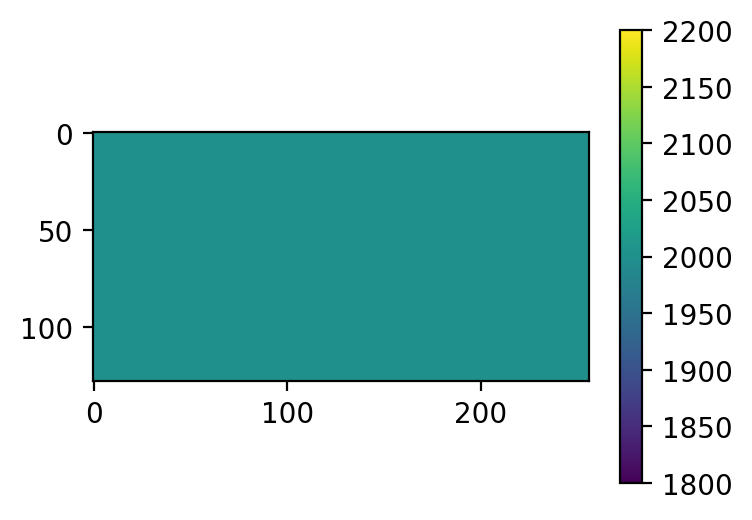

In [271]:
plt.imshow(models_array[0, ...].T)
plt.colorbar()

In [272]:
fn_numpy_prefix = 'linan_greens_function/homogeneous'

In [273]:
domain.set_model_from_numpy(models_array, geometry=geometry_dict, fn_prefix=fn_numpy_prefix, solver='matterhorn', create_hdf5=True)

linan_greens_function/homogeneous
linan_greens_function/homogeneous.h5


In [274]:
domain

In [275]:
# pprint(domain.get_domain_dict())

<div class="alert alert-info">
    <h2>Time and frequency setup</h2>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also directly define the number of time steps.

In [276]:
time_step_in_seconds = 4e-4
start_time_in_seconds = 0.0
# time_shift_in_seconds = 1.0
end_time_in_seconds = 2000 * time_step_in_seconds

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

In [277]:
# This will also become a function to be consistent with the other sections
time_dict = get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

In [278]:
# pprint(time_dict)

<div class="alert alert-info">
    <h2>Input setup</h2>
</div>

Here, we define the input (sources) which will generate the wavefields. We can define a single point source or an array (boundary) of point sources. In the example below, we define a point source characterised by a Ricker wavelet as source time function.

In [325]:
# Use a Ricker wavelet as source time function
center_frequency = 75.0
stf = wavelets.RickerWavelet(t, fc=center_frequency, delay=1.5, delay_type='c', create_binary=True, fn_prefix='source')

Additionally, we can also load a user-defined wavelet from a binary file.

In [326]:
# filename = 'user_defined_ricker_20hz.bin'
# stf = UserWavelet(filename, nt=t.size)

In [327]:
# Define a point source
name = "source0"
location = (240.0, 0.0, 100.0)
spatial_type = "q"
scale = 1.

source0 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [328]:
# pprint(source0.get_source_dict())

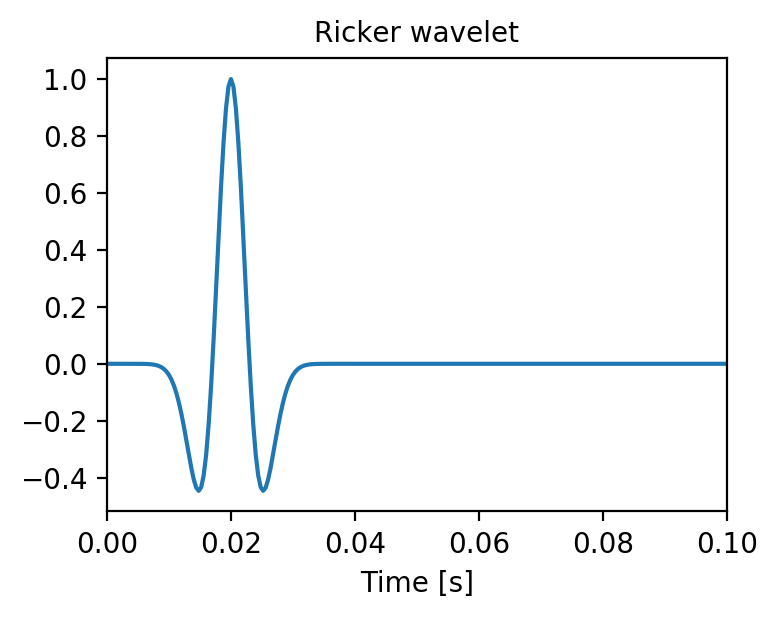

In [329]:
# Plot the source time function
# This will be implemented in the PointSource class
plt.plot(t, source0.stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')
_ = plt.xlim([0, 0.1])

<div class="alert alert-info">
    <h2>Output setup</h2>
</div>

Here, we definte the output of the simulation. Now we create two shot gathers.

In [285]:
# First we create a general gather object
start_timestep = 0
end_timestep = number_of_timesteps - 1
timestep_increment = 1

gather = ShotGather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [286]:
n = domain.get_domain_dict()['geometry']['number-of-cells']
d = domain.get_domain_dict()['geometry']['cell-size']

# Number of receivers
nr = n[0]
# Receiver z-value
rz0 = 40.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nr * d[0]

In [287]:
# Then we define multiple receiver arrays
rec0 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather')
# rec1 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename='vx_gather')

Additionally, we create time snapshots.

In [288]:
# First we create a general snapshot object
start_timestep = 0
end_timestep = number_of_timesteps - 1
timestep_increment = 100

snapshot = TimeSlice(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [289]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

In [290]:
# Then we define two slices
slice0 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V10X', filename='vx_slice')
slice1 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V01Z', filename='vz_slice')

Additionally, we create DFT slices.

In [312]:
# First we create a general snapshot object
# dft_frequencies = list(range(5, 81, 5))
dft_frequencies = [5., 20.]

dft = DFTSlice(dft_frequencies=dft_frequencies, fmt='su')

In [313]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

In [314]:
# Then we define two slices
dft_slice0 = dft.add_slices(axis=slice_axis, slice_index=slice_index, attribute='S00XX', filename='sxx_dft_slice')

In [315]:
# pprint(gather.get_receivers_dict())
# pprint(snapshot.get_slices_dict())

<div class="alert alert-info">
    <h2>Physics setup</h2>
</div>

In [316]:
pml_dict = get_pml_dict(fs=False, width=10, power=4, frequency=center_frequency, vel=vp0)

In [317]:
physics_dict = get_physics_dict(order=4, boundaries=[pml_dict,])

In [318]:
# pprint(physics_dict)

<div class="alert alert-info">
    <h2>Generate TOML file</h2>
</div>

In [330]:
# Generate the complete input dictionary.
def get_input_file_dict():
    return {
        "general": general_dict,
        "domain": domain.get_domain_dict(),
        "time": time_dict,
        "physics": physics_dict,
        "source": {"point-source": [source0.get_source_dict(),]},
        "output": {
            "gather": gather.get_receivers_dict(),
            "slice_time": snapshot.get_slices_dict(),
            "slice_dft": dft.get_slices_dict(),
        }
    }

input_file_dict = get_input_file_dict()

# Thoughts:
# For now, the final complete input dictionary is created manually
# joining the required smaller sectional dictionaries.
# Is there a better way to do so?

In [331]:
# Create the Cervino input from a dictionary
marmousi.from_dict(input_file_dict)

In [332]:
pprint(marmousi.get_input_dict())

{'domain': {'dimension': 3,
            'geometry': {'cell-size': (2.0, 2.0, 2.0),
                         'number-of-cells': (256, 1, 128),
                         'origin': (0.0, 0.0, 0.0)},
            'model': {'filename': 'linan_greens_function/homogeneous.h5',
                      'format': 'hdf5',
                      'required-models': ('vp', 'rho')}},
 'general': {'desc': 'Greens function computation for Linan',
             'site': 'aug05',
             'solver': 'matterhorn',
             'user': 'bfilippo'},
 'output': {'gather': {'end-timestep': 1999,
                       'format': 'su',
                       'receivers': [{'attribute': 'V01Z',
                                      'filename-prefix': 'vz_gather',
                                      'number-of-receivers': 256,
                                      'receiver-increment': (2.0, 0.0, 0.0),
                                      'receiver-origin': (0.0, 0.0, 40.0)}],
                       'start-timeste

In [301]:
# Create the Cervino input from a TOML file
# marmousi.from_toml('marmousi_for_cervino.toml')

In [302]:
# pprint(marmousi.get_input())

In [303]:
# Look at the file we've written
# Linux
# !cat "marmousi_for_cervino.toml"
# Windows
# !type "marmousi_for_cervino.toml"

<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

This launches the simulation on the local workstation/laptop.

In [304]:
# mh_file = marmousi.to_solver_input()

In [305]:
# mh_file

In [306]:
# !cat marmousi_v10.sim

In [333]:
run_dict = {
    'solver_binary': 'matterhorn',
    'progress': True,
    'verbose': False,
    'ncores': 24
}

In [334]:
result = marmousi.run(run_dict)

In [335]:
# result.stdout.readlines()

In [198]:
marmousi._site

'local'

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [336]:
filename = 'vz_gather.su'
# filename = 'euler/vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

True

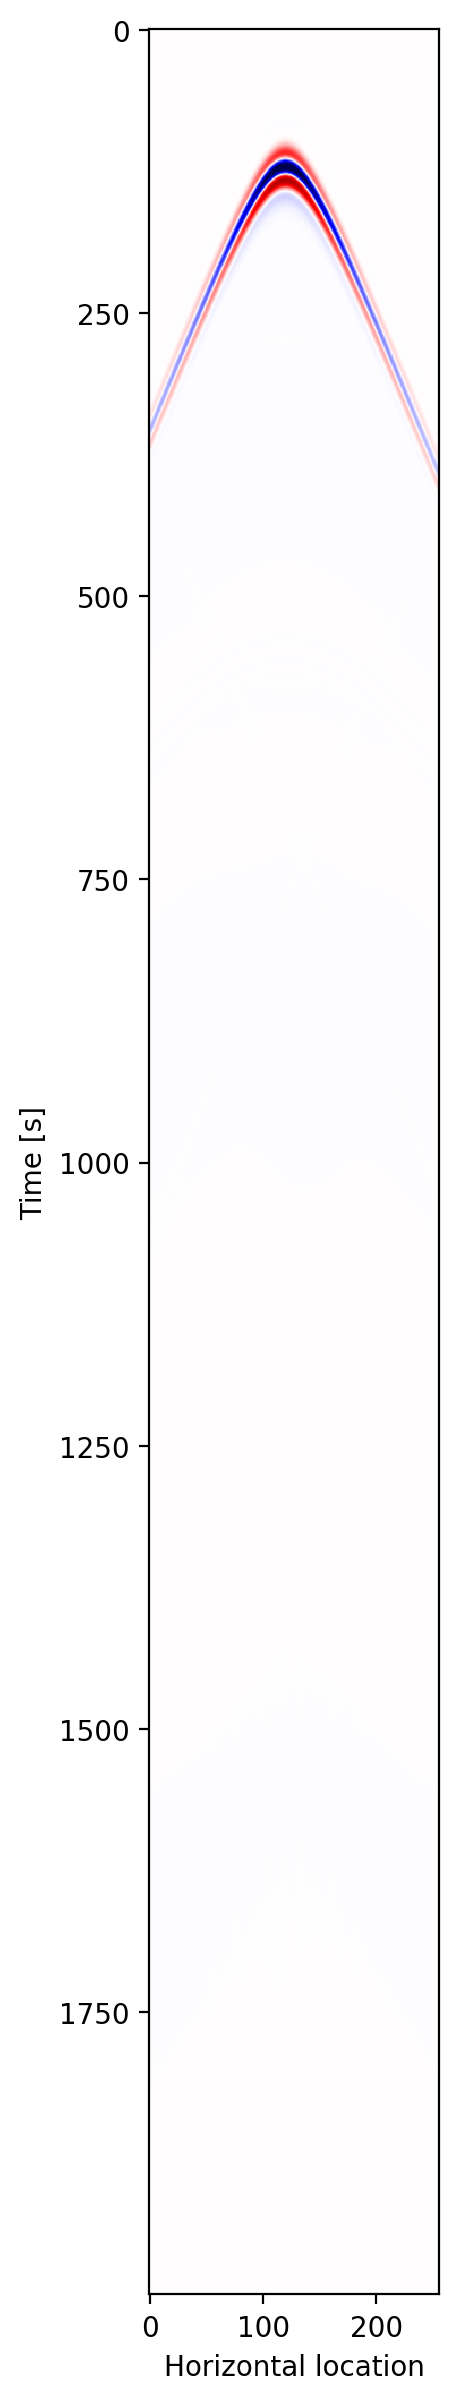

In [339]:
clip = 1e-2
vmin, vmax = -clip, clip

# Figure
figsize=(10, 15)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [340]:
sufile.close()

<div class="alert alert-info">
    <h3>DFTs</h3>
</div>

In [341]:
slice_size_new = (2, geometry_dict['number-of-cells'][2], geometry_dict['number-of-cells'][0])
dft_real_mh = np.fromfile('sxx_dft_slice_real_0.su', dtype=np.float32).reshape(slice_size_new)
dft_imag_mh = np.fromfile('sxx_dft_slice_imag_0.su', dtype=np.float32).reshape(slice_size_new)

In [342]:
plt.rc('figure', dpi=200)
plt.rc('figure', figsize=(4, 3))
medium_size = 10
plt.rc('axes', titlesize=medium_size)
plt.rc('axes', labelsize=medium_size)

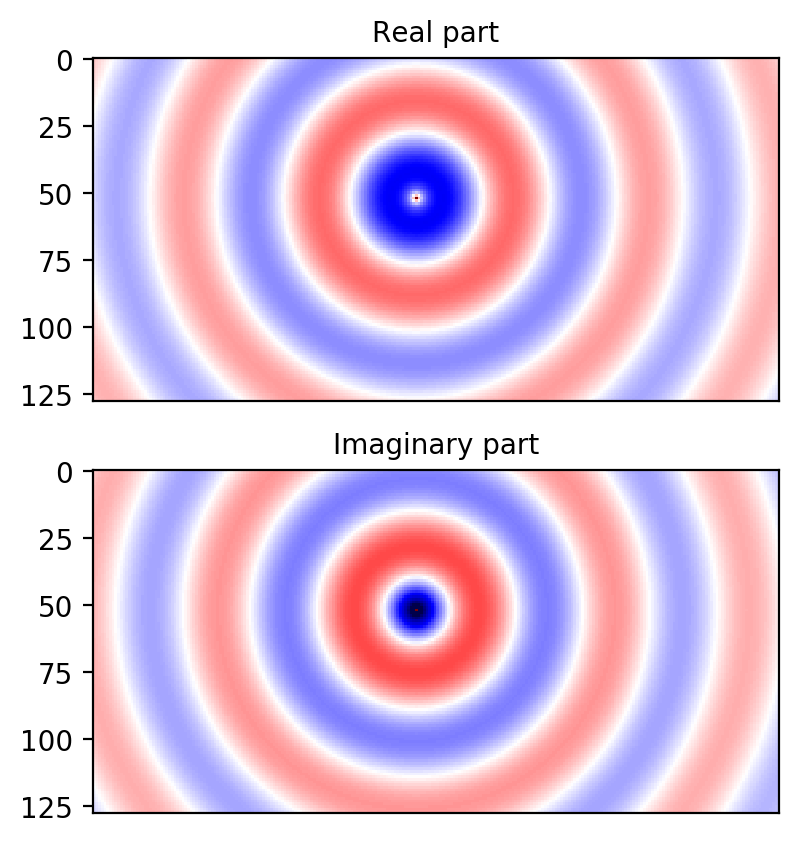

In [347]:
# Choose a frequency index
ifreq = 1

figsize = (5, 5)
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=False, sharey=False, facecolor='white')

clip=1e+5
vmin, vmax = -clip, clip

_ = axes[0].imshow(dft_real_mh[ifreq, ...], vmin=vmin, vmax=vmax, cmap=plt.cm.seismic)
_ = axes[0].set_title('Real part')
_ = axes[0].set_xticks([])
_ = axes[0].grid(False)

clip=1e+5
vmin, vmax = -clip, clip

_ = axes[1].imshow(dft_imag_mh[ifreq, ...], vmin=vmin, vmax=vmax, cmap=plt.cm.seismic)
_ = axes[1].set_title('Imaginary part')
_ = axes[1].set_xticks([])
_ = axes[1].grid(False)